In [1]:
%load_ext autoreload
%autoreload 2

import torch, click, numpy as np

import swyft
from utils import *
from plot import *

from tqdm import tqdm



DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

import matplotlib.colors
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'


In [2]:
m = 1
nsub = 5
nsim = 50000

nmbins = 5

lr = 1e-3
factor = 1e-1
patience = 5

system_name = "ngc4414"

In [3]:
# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.Store.load(path=sim_path)
print(f'Store has {len(store)} simulations.')

config = get_config(system_name, str(nsub), str(m))

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

# dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)

Store _M_m1_nsub5_nsim50000 exists!
Loading existing store.
Store has 49701 simulations.
Image has L = 40.


In [4]:
# Load network
mre_name, mre_path = get_mre_path(sim_name, nmbins, lr, factor, patience)
print(f'Loading {mre_name}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmbins, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

Loading UNet_M_m1_nsub5_nsim50000_nmbins5_lr-3.0_fac-1.0_pat5.pt!


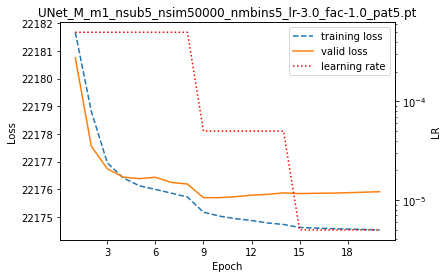

In [5]:
plot_losses(mre, title = mre_name, save_name = mre_name)

In [6]:
def get_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmbins+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    
    coord_full = []
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1).to(DEVICE, dtype = torch.float)
        coord_full.append(coord)

    coords = [coord_empty] + coord_full
    return coords, coord_empty, coord_full, m_centers, m_edges 

def get_obs(store, i = -1):
    obs0_i = np.random.randint(0, len(store)) if i == -1 else i
    print(f'i = {obs0_i}')
    
    obs0 = store[obs0_i][0]
    v0 = store[obs0_i][1]

    obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = tensor(v0).unsqueeze(0).to(DEVICE)
    
    return obs0, v0, obs0_i

coords, coord_empty, coord_full, m_centers, m_edges = get_coords(nmbins, L)

mbins = np.linspace(lows[2], highs[2], nmbins + 1)
title_mbins = [f'mass {mbins[i]} - {mbins[i+1]}' for i in range(nmbins)]
title_halos = [f'{j} {k}' for j in ['no halo', 'halo'] for k in title_mbins ]
titles = [f'{i} {j}' for i in ['target', 'ratio '] for j in title_halos ]


In [7]:
prior = nsub/(L*L)/nmbins
prior0 = 1 - prior
prior1 = prior
priors = np.repeat(np.array([prior0, prior1]), nmbins) 

print(f'prior no halo \t{prior0}\npario halo \t{prior1}')

prior no halo 	0.999375
pario halo 	0.000625


In [8]:
def get_pred(obs0_i = -1):
    
    # Get observation and targets
    obs0, v0, obs0_i = get_obs(store, obs0_i)
    targets = mre.network.parameter_transform(v0).squeeze()

    # Get logratios
    logratios = np.zeros((nmbins*2, L, L))
    logratios[:nmbins] = mre.network(obs0, coord_empty).view(nmbins*2, L, L)[:nmbins]
    logratios[nmbins:] = torch.stack([
        mre.network(obs0, coord).view(nmbins*2, L, L)[i+nmbins] for i, coord in enumerate(coord_full)
    ])
        
    # Posterior 
    posts = np.exp(logratios) * (priors)[:, np.newaxis, np.newaxis]
    posts_sum = np.sum(posts.reshape(2, nmbins, L, L).transpose([1,0,2,3]), axis = 1)
    posts_sum = np.tile(posts_sum, (2,1,1))
    posts_norm = posts / posts_sum
    
    # Target coordinates
    x, y = v0[0][::3].numpy(), v0[0][1::3].numpy()
    m_i = np.where(targets[nmbins:] == 1)[0]
    target_coords = np.array((m_i, x, y)).T
    
    scatter = np.array([np.array(np.where(targets[nmbins:] == 1))[i] for i in [1, 2, 0]])
    
    return posts_norm[nmbins:], target_coords, scatter, obs0_i, posts



## Final results

In [9]:
post, target_coords, scatter, obs0_i, posts_all = get_pred()

i = 26091


In [10]:
def find_nrows(l):
    a = np.array([(i, l/i, i+l/i) for i in range(1, l) if (l/i).is_integer()])
    i_min = np.argmin(a[:, -1], axis = 0)
    return int(a[i_min].min())

i = 38225
16.259094940371433


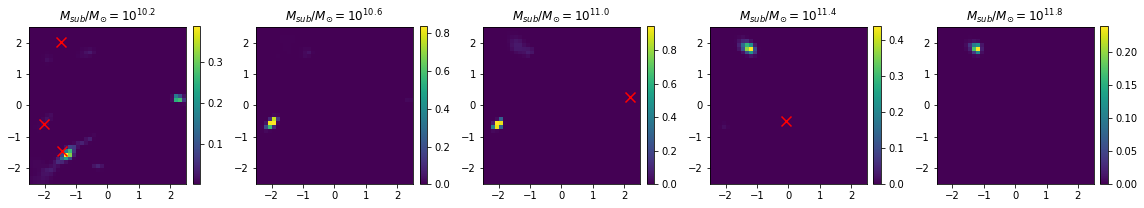

In [11]:
for _ in range(1):
    post, target_coords, scatter, obs0_i, posts_all = get_pred()
    
    print(np.sum(post))
    
    nrows = find_nrows(len(post))
    titles = [rf'$M_{{sub}}/M_{{\odot}} = 10^{ {m} }$' for m in np.log10(m_centers.numpy())]

    log = False
    plt_imshow(post, nrows, target_coords = target_coords, cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)


# Lava lamp

In [12]:
assert 1 == 2

AssertionError: 

In [12]:
def get_alphas(post):
    print(post_min, post_max)
    post = ( post - post_min ) / post_max

    a, b = 50, 1
    alphas = 1 - b * np.exp( - a * post)
    
    return alphas

def normalize(d):
    d -= d.min()
    d /= d.max()
    return d

In [13]:
def cuboid_data(center, size=(1,1,1)):
    # code taken from
    # http://stackoverflow.com/questions/30715083/python-plotting-a-wireframe-3d-cuboid?noredirect=1&lq=1
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return np.array((x, y, z))

def plotCubeAt(pos=(0,0,0), c="b", alpha=1, ax=None):
    # Plotting N cube elements at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( (pos[0],pos[1],pos[2]) )
        ax.plot_surface(X, Y, Z, color=c, rstride=1, cstride=1, alpha=alpha)

def plotMatrix(ax, x, y, z, threshold, data, cmap=plt.cm.viridis, cax=None, alpha=1):
    # plot a Matrix 
    norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
    colors = lambda i,j,k : matplotlib.cm.ScalarMappable(norm=norm,cmap = cmap).to_rgba(data[i,j,k]) 
    alphas = lambda i,j,k : normalize(data)[i,j,k] 
    for i, xi in enumerate(x):
            for j, yi in enumerate(y):
                for k, zi, in enumerate(z):
                    if data[i,j,k] > threshold:
                        plotCubeAt(pos=(xi, yi, zi), c=colors(i,j,k), alpha=alphas(i,j,k), ax=ax)
                    
                    
def plotLava(obs0_i = -1):
    post, _, scatter, obs0_i, _ = get_pred(obs0_i = obs0_i)
    
    # x and y and z coordinates
    x = np.array(range(21)) #np.linspace(0,9,11) #
    y = np.array(range(10,15))
    z = np.array(range(15,20))
    # data_value = np.random.randint(1,4, size=(len(x), len(y), len(z)) )
    data_value = np.random.rand(len(x), len(y), len(z))

    x = y = np.arange(L) #np.linspace(0, 1, L)
    z = np.arange(len(m_centers)) #m_centers.numpy()
    data_value = np.transpose(post, [1,2,0])

    azims = [10., 100., 190., 250.]
    # azims = [10.]

    print(data_value.shape)
    plot_name = f'{mre_name}_obs0_i={obs0_i}'
    print(f'plot_name {plot_name}')

    fig = plt.figure(figsize=(18,15))

    for i, azim in enumerate(azims):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        plotMatrix(ax, x, y, z, data_value)

        ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)

        ax.view_init(elev=10., azim=azim)

        labelsize = 15
        ax.set_xlabel(r'$x\ [\deg]$', fontsize = labelsize)
        ax.set_ylabel(r'$y\ [\deg]$', fontsize = labelsize)
        ax.set_zlabel(r'$log_{10}(M_{sub}/M_{\odot})$', fontsize = labelsize)

        ax.set_xticks(np.linspace(0, L, 11)[1::2])
        ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::2])
        ax.set_yticks(np.linspace(0, L, 11)[1::2])
        ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::2])
        ax.set_zticks(z)
        ax.set_zticklabels(np.log10(m_centers.numpy()))





    fig.subplots_adjust(right=0.8)
    ax_cb = fig.add_axes([0.85, 0.15, 0.02, 0.7])

    norm = matplotlib.colors.Normalize(vmin=data_value.min(), vmax=data_value.max())
    cbar = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.viridis,
                                    norm=norm,
                                    orientation='vertical')  

#     plt.savefig(f'figs/lava_{plot_name}.png',bbox_inches='tight')
    plt.show()
    
# for _ in range(1):
#     plotLava(obs0_i = -1)

i = 37784


/home/eliasd/.pyenv/versions/3.9.7/envs/lens-3.9.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


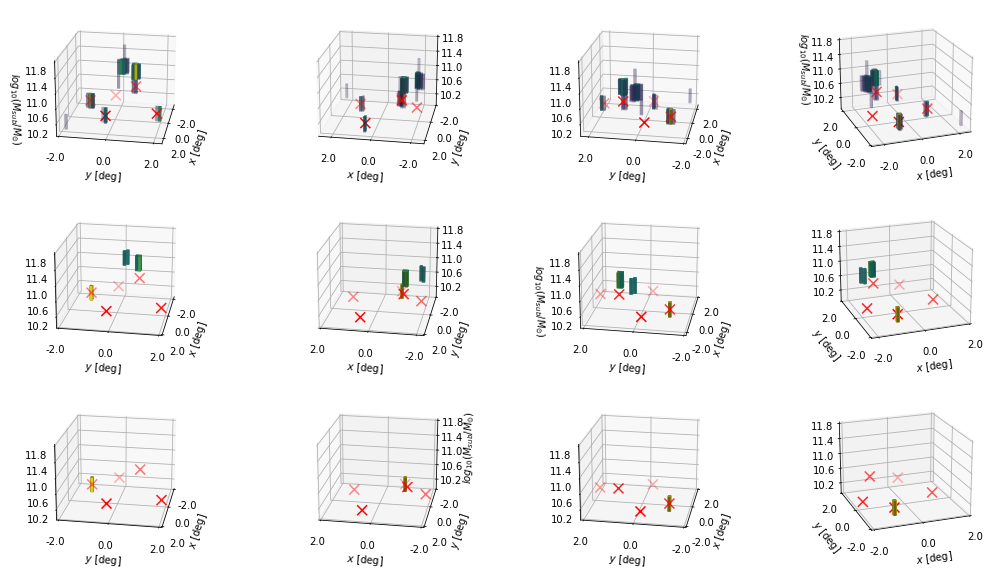

In [20]:
post, _, scatter, _, _ = get_pred(obs0_i = 37784)
x = y = np.arange(L) #np.linspace(0, 1, L)
z = np.arange(len(m_centers)) #m_centers.numpy()
data_value = np.transpose(post, [1,2,0])

fig = plt.figure(figsize=(18,10), tight_layout=True)

azims = [10., 100., 190., 250.]
thresholds = [0.1, 0.5, 0.8]

count = 0
for threshold in thresholds:
    for azim in azims:
        ax = fig.add_subplot(len(thresholds), len(azims), count+1, projection='3d')
        
        plotMatrix(ax, x, y, z, threshold, data_value)
        ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)
        ax.view_init(elev=20., azim=azim)
        
        labelsize = 10
        ax.set_xlabel(r'$x\ [\deg]$', fontsize = labelsize)
        ax.set_ylabel(r'$y\ [\deg]$', fontsize = labelsize)
        if count % 3 == 0: ax.set_zlabel(r'$log_{10}(M_{sub}/M_{\odot})$', fontsize = labelsize)
#         print( )

        ax.set_xticks(np.linspace(0, L, 11)[1::4])
        ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::4])
        ax.set_yticks(np.linspace(0, L, 11)[1::4])
        ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::4])
        ax.set_zticks(z)
        ax.set_zticklabels(np.log10(m_centers.numpy()))

        
        count+=1

i = 2532


/scratch/ipykernel_13839/4281874238.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  HTML(anim.to_html5_video())


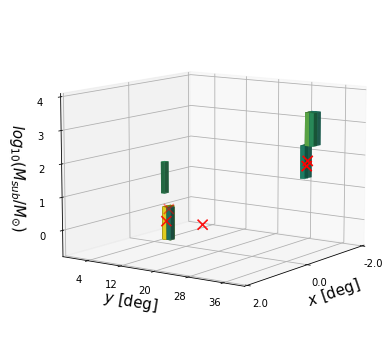

In [174]:
post, _, scatter, _, _ = get_pred(obs0_i = -1)
x = y = np.arange(L) #np.linspace(0, 1, L)
z = np.arange(len(m_centers)) #m_centers.numpy()
data_value = np.transpose(post, [1,2,0])

fig = plt.figure(figsize=(18,5))


ax = fig.add_subplot(1, 1, i+1, projection='3d')

def init():
    plotMatrix(ax, x, y, z, threshold, data_value)
    
    ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)

    
    labelsize = 15
    ax.set_xlabel(r'$x\ [\deg]$', fontsize = labelsize)
    ax.set_ylabel(r'$y\ [\deg]$', fontsize = labelsize)
    ax.set_zlabel(r'$log_{10}(M_{sub}/M_{\odot})$', fontsize = labelsize)

    ax.set_xticks(np.linspace(0, L, 11)[1::4])
    ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::4])
    ax.set_yticks(np.linspace(0, L, 11)[1::2])
#     ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::2])
    ax.set_zticks(z)
#     ax.set_zticklabels(np.log10(m_centers.numpy()))
    return fig,
    
def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# plt.tight_layout()


# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=36, interval=20, blit=True)

HTML(anim.to_html5_video())

# Save
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# fig.subplots_adjust(right=0.8)
# ax_cb = fig.add_axes([0.85, 0.15, 0.02, 0.7])

# norm = matplotlib.colors.Normalize(vmin=data_value.min(), vmax=data_value.max())
# cbar = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.viridis,
#                             norm=norm,
#                             orientation='vertical')  

# def animate(i):
# #     for ax in axs:
#     ax.view_init(elev=30., azim=3.6*i)
#     return fig,

# ani = animation.FuncAnimation(fig, animate, #init_func=init,
#                                frames=10, interval=100, blit=True)    

# HTML(ani.to_html5_video())

# # ani.save('test.gif')

i = 12464


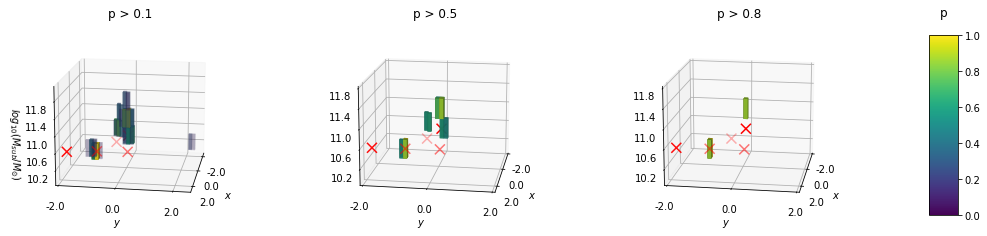

In [82]:
post, _, scatter, _, _ = get_pred(obs0_i = -1)
x = y = np.arange(L) #np.linspace(0, 1, L)
z = np.arange(len(m_centers)) #m_centers.numpy()
data_value = np.transpose(post, [1,2,0])

fig = plt.figure(figsize = (20,5))


axs = ([])

for i, threshold in enumerate([0.1, 0.5, 0.8]):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    plotMatrix(ax, x, y, z, threshold, data_value)
    
    ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)

    
    labelsize = 10
    ax.set_xlabel(r'$x$', fontsize = labelsize)
    ax.set_ylabel(r'$y$', fontsize = labelsize)
    if i == 0: ax.set_zlabel(r'$log_{10}(M_{sub}/M_{\odot})$', fontsize = labelsize)
    
    tickskip = 4
    ax.set_xticks(np.linspace(0, L, 11)[1::tickskip])
    ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
    ax.set_yticks(np.linspace(0, L, 11)[1::tickskip])
    ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
    ax.set_zticks(z)
    ax.set_zticklabels(np.log10(m_centers.numpy()))
    
    axs.append(ax)

    
    ax.set_title(f'p > {threshold}')



# ax = fig.add_subplot(1, 4, 4)
# ax.axis('off')
ax = fig.add_axes([0.75, 0.25, 0.02, 0.5])
norm = matplotlib.colors.Normalize(vmin=data_value.min(), vmax=data_value.max())
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.cm.viridis,
                            norm=norm,
                            orientation='vertical')  
cbar.ax.set_title('p', pad = 19)

fig.subplots_adjust(wspace=0.5)

def animate(i):
    for ax in axs:
        ax.view_init(elev=15., azim=i)
    return fig,

ani = animation.FuncAnimation(fig, animate, #init_func=init,
                               frames=10, interval=200, blit=True)    

# ani.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


HTML(ani.to_html5_video())

# ani.save('test.gif')

In [15]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

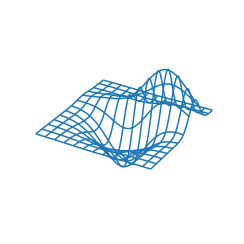

In [81]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

# load some test data for demonstration and plot a wireframe
X, Y, Z = axes3d.get_test_data(0.1)
ax.grid(False)
ax.set_axis_off()

def init():
    ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)    

# HTML(ani.to_html5_video())

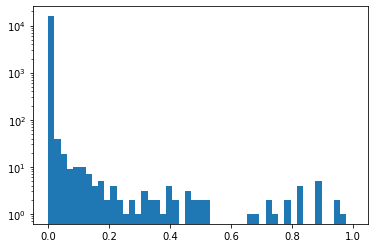

In [26]:
plt.hist(post.flatten(), bins = np.linspace(0, 1))
plt.yscale('log')

In [30]:
post, _, scatter, _, _ = get_pred(obs0_i = obs0_i)

x = y = np.arange(L) #np.linspace(0, 1, L)
z = np.arange(len(m_centers)) #m_centers.numpy()
data_value = np.transpose(post, [1,2,0])

i = 48016


In [29]:
data_value.shape

(40, 40, 10)

In [ ]:
    post, _, scatter, obs0_i, _ = get_pred(obs0_i = obs0_i)
    
    # x and y and z coordinates
    x = np.array(range(21)) #np.linspace(0,9,11) #
    y = np.array(range(10,15))
    z = np.array(range(15,20))
    # data_value = np.random.randint(1,4, size=(len(x), len(y), len(z)) )
    data_value = np.random.rand(len(x), len(y), len(z))

    x = y = np.arange(L) #np.linspace(0, 1, L)
    z = np.arange(len(m_centers)) #m_centers.numpy()
    data_value = np.transpose(post, [1,2,0])

    azims = [10., 100., 190., 250.]
    # azims = [10.]

    print(data_value.shape)
    plot_name = f'{mre_name}_obs0_i={obs0_i}'
    print(f'plot_name {plot_name}')

    fig = plt.figure(figsize=(18,15))

    for i, azim in enumerate(azims):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
#         plotMatrix(ax, x, y, z, data_value)

        ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)

        ax.view_init(elev=10., azim=azim)

        labelsize = 15
        ax.set_xlabel(r'$x\ [\deg]$', fontsize = labelsize)
        ax.set_ylabel(r'$y\ [\deg]$', fontsize = labelsize)
        ax.set_zlabel(r'$log_{10}(M_{sub}/M_{\odot})$', fontsize = labelsize)

        ax.set_xticks(np.linspace(0, L, 11)[1::2])
        ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::2])
        ax.set_yticks(np.linspace(0, L, 11)[1::2])
        ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::2])
        ax.set_zticks(z)
        ax.set_zticklabels(np.log10(m_centers.numpy()))





    fig.subplots_adjust(right=0.8)
    ax_cb = fig.add_axes([0.85, 0.15, 0.02, 0.7])

    norm = matplotlib.colors.Normalize(vmin=data_value.min(), vmax=data_value.max())
    cbar = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=plt.cm.viridis,
                                    norm=norm,
                                    orientation='vertical')  

    plt.savefig(f'figs/lava_{plot_name}.png',bbox_inches='tight')
    plt.show()